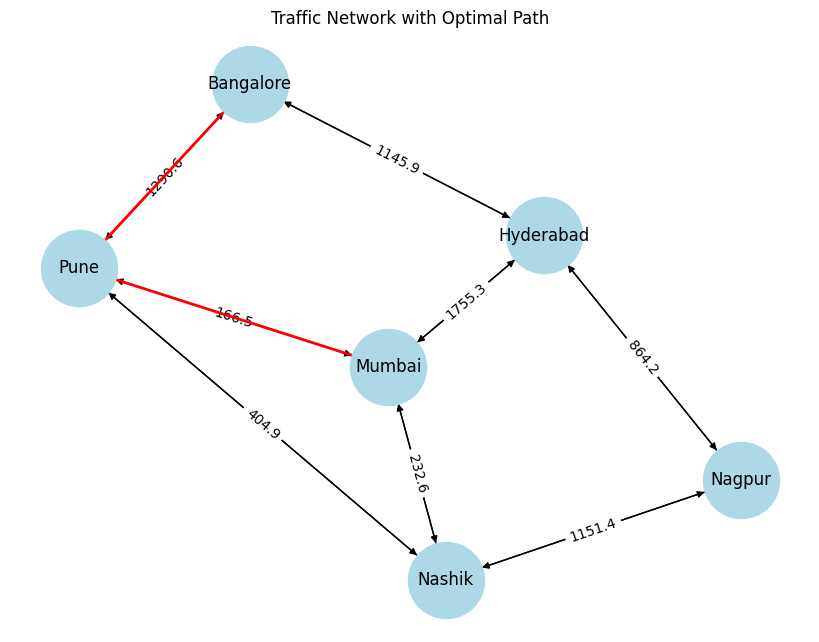

Truck1 (TRUCK) Route: Mumbai -> Pune -> Bangalore


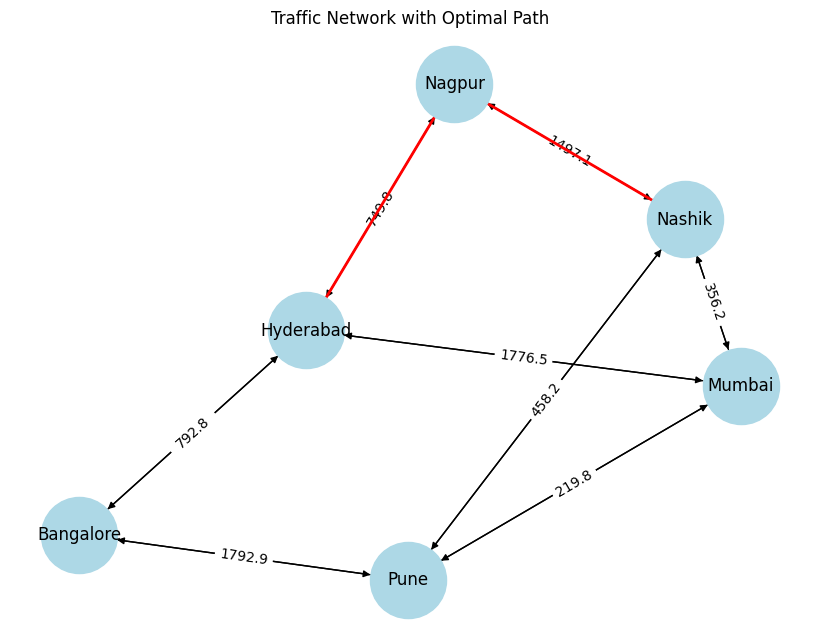

Car1 (CAR) Route: Hyderabad -> Nagpur -> Nashik
Traffic light at Mumbai turning GREEN for 12s due to congestion 24
Traffic light at Pune turning GREEN for 23s due to congestion 46
Traffic light at Nashik turning GREEN for 48s due to congestion 97
Traffic light at Nagpur turning GREEN for 37s due to congestion 74
Traffic light at Hyderabad turning GREEN for 14s due to congestion 29
Traffic light at Bangalore turning GREEN for 49s due to congestion 98
Truck1 (TRUCK) traveling from Mumbai to Pune (Time: 5Hr)
Car1 (CAR) traveling from Hyderabad to Nagpur (Time: 12Hr)
Truck1 (TRUCK) traveling from Pune to Bangalore (Time: 28Hr)
Car1 (CAR) traveling from Nagpur to Nashik (Time: 14Hr)
Car1 (CAR) reached destination Nashik in 26Hr
Truck1 (TRUCK) reached destination Bangalore in 33Hr
Traffic light at Mumbai turning GREEN for 16s due to congestion 32
Traffic light at Hyderabad turning GREEN for 24s due to congestion 48
Traffic light at Pune turning GREEN for 10s due to congestion 11
Traffic ligh

In [4]:
import networkx as nx
import simpy
import graphviz
import random
import enum
import matplotlib.pyplot as plt

class VehicleType(enum.Enum):
    TRUCK = 1
    CAR = 2
    BUS = 3
    MOTORCYCLE = 4

class Vehicle:
    SPEED_MULTIPLIERS = {
        VehicleType.TRUCK: 0.6,
        VehicleType.CAR: 1.0,
        VehicleType.BUS: 0.8,
        VehicleType.MOTORCYCLE: 1.5
    }

    def __init__(self, env, vehicle_id, vehicle_type, route, road_network, traffic_lights):
        self.env = env
        self.vehicle_id = vehicle_id
        self.vehicle_type = vehicle_type
        self.route = route
        self.road_network = road_network
        self.traffic_lights = traffic_lights
        self.speed_multiplier = self.SPEED_MULTIPLIERS[vehicle_type]
        print(f"{self.vehicle_id} ({vehicle_type.name}) Route: {' -> '.join(self.route)}")

    def drive(self):
        total_time = 0
        for i in range(len(self.route) - 1):
            current_node = self.route[i]
            next_node = self.route[i + 1]
            
            road_details = self.road_network[current_node][next_node]
            congestion_factor = random.uniform(1.0, 2.5)
            base_travel_time = road_details['distance'] / road_details['max_speed'] * congestion_factor
            travel_time = int(base_travel_time / self.speed_multiplier)
            
            if self.traffic_lights[current_node].state == "RED":
                delay = self.traffic_lights[current_node].dynamic_delay()
                print(f"{self.vehicle_id} ({self.vehicle_type.name}) waiting at red light in {current_node} for {delay}s")
                total_time += delay
                yield self.env.timeout(delay)
            
            print(f"{self.vehicle_id} ({self.vehicle_type.name}) traveling from {current_node} to {next_node} (Time: {travel_time}Hr)")
            yield self.env.timeout(travel_time)
            total_time += travel_time
        
        print(f"{self.vehicle_id} ({self.vehicle_type.name}) reached destination {self.route[-1]} in {total_time}Hr")

class TrafficLight:
    def __init__(self, env, location, junction_type, cycle_time=60):
        self.env = env
        self.location = location
        self.junction_type = junction_type
        self.cycle_time = cycle_time
        self.state = "RED"
        self.process = env.process(self.run())

    def run(self):
        while True:
            traffic_density = random.randint(1, 100)
            green_time = self.optimize_green_time(traffic_density)
            print(f"Traffic light at {self.location} turning GREEN for {green_time}s due to congestion {traffic_density}")
            self.state = "GREEN"
            yield self.env.timeout(green_time)
            self.state = "RED"
            yield self.env.timeout(self.cycle_time - green_time)

    def optimize_green_time(self, traffic_density):
        return max(10, min(60, traffic_density // 2))
    
    def dynamic_delay(self):
        return random.randint(10, 60)

class TrafficSimulation:
    def __init__(self):
        self.env = simpy.Environment()
        self.road_network = self.create_road_network()
        self.vehicles = []
        self.traffic_lights = {}
        self.setup_traffic_lights()
        self.env.process(self.run_simulation())

    def create_road_network(self):
        return {
            "Mumbai": {
                "Pune": {"distance": 150, "road_type": "highway", "max_speed": 100},
                "Nashik": {"distance": 180, "road_type": "highway", "max_speed": 80},
                "Hyderabad": {"distance": 720, "road_type": "national_highway", "max_speed": 120}
            },
            "Pune": {
                "Mumbai": {"distance": 150, "road_type": "highway", "max_speed": 100},
                "Nashik": {"distance": 200, "road_type": "state_highway", "max_speed": 60},
                "Bangalore": {"distance": 840, "road_type": "national_highway", "max_speed": 100}
            },
            "Nashik": {
                "Pune": {"distance": 200, "road_type": "state_highway", "max_speed": 60},
                "Nagpur": {"distance": 600, "road_type": "national_highway", "max_speed": 80},
                "Mumbai": {"distance": 180, "road_type": "highway", "max_speed": 80}
            },
            "Nagpur": {
                "Nashik": {"distance": 600, "road_type": "national_highway", "max_speed": 80},
                "Hyderabad": {"distance": 500, "road_type": "national_highway", "max_speed": 100}
            },
            "Hyderabad": {
                "Nagpur": {"distance": 500, "road_type": "national_highway", "max_speed": 100},
                "Bangalore": {"distance": 570, "road_type": "national_highway", "max_speed": 120},
                "Mumbai": {"distance": 720, "road_type": "national_highway", "max_speed": 120}
            },
            "Bangalore": {
                "Pune": {"distance": 840, "road_type": "national_highway", "max_speed": 100},
                "Hyderabad": {"distance": 570, "road_type": "national_highway", "max_speed": 120}
            }
        }

    def setup_traffic_lights(self):
        for location in self.road_network.keys():
            self.traffic_lights[location] = TrafficLight(self.env, location, "city_intersection")

    def add_vehicle(self, vehicle_id, vehicle_type, start, destination):
        route = self.dijkstra_shortest_path(start, destination)
        if not route:
            print(f"No route found for {vehicle_id} from {start} to {destination}")
            return
        vehicle = Vehicle(self.env, vehicle_id, vehicle_type, route, self.road_network, self.traffic_lights)
        self.vehicles.append(vehicle)
        self.env.process(vehicle.drive())

    def run_simulation(self):
        while True:
            yield self.env.timeout(5)

    def run(self, simulation_time=2000):
        self.env.run(until=simulation_time)

    def dijkstra_shortest_path(self, start, goal):
        G = nx.DiGraph()
        for src, dests in self.road_network.items():
            for dest, details in dests.items():
                congestion_factor = random.uniform(1.0, 2.5)
                weight = details['distance'] * congestion_factor
                G.add_edge(src, dest, weight=weight)

        shortest_path = nx.shortest_path(G, source=start, target=goal, weight='weight')
        self.visualize_graph(G, shortest_path)
        return shortest_path

    def visualize_graph(self, G, shortest_path):
        pos = nx.spring_layout(G)
        plt.figure(figsize=(8, 6))
        
        edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}
        
        nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        
        path_edges = list(zip(shortest_path, shortest_path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
        
        plt.title("Traffic Network with Optimal Path")
        plt.show()

if __name__ == "__main__":
    sim = TrafficSimulation()
    sim.add_vehicle("Truck1", VehicleType.TRUCK, "Mumbai", "Bangalore")
    sim.add_vehicle("Car1", VehicleType.CAR, "Hyderabad", "Nashik")
    sim.run(2000)